In [1]:
import os
import matplotlib.pyplot as plt

In [2]:
base_dir = './data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## VGG16 is 550MB large in HDF5 format, 16 trainable layers

In [3]:
from keras.applications import VGG16

vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))

vgg_model.summary()

/home/ubuntu/anaconda/envs/py36-venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
from keras import models
from keras import layers

model = models.Sequential()

model.add(vgg_model)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [5]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))

vgg_model.trainable = False

print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 30
Number of trainable weights after freezing the conv base: 4


In [6]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc']
             )

## Data augmentation applied only on training dataset.

the images presented to the input layer should be square. Using square inputs allows us to take
advantage of linear algebra optimization libraries.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')



In [8]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 33s 330ms/step - loss: 0.6473 - acc: 0.6225 - val_loss: 0.4745 - val_acc: 0.8103
Epoch 2/30
100/100 [==============================] - 31s 306ms/step - loss: 0.5153 - acc: 0.7463 - val_loss: 0.3915 - val_acc: 0.8490
Epoch 3/30
100/100 [==============================] - 30s 298ms/step - loss: 0.4701 - acc: 0.7769 - val_loss: 0.3572 - val_acc: 0.8553
Epoch 4/30
100/100 [==============================] - 31s 312ms/step - loss: 0.4437 - acc: 0.7891 - val_loss: 0.3295 - val_acc: 0.8680
Epoch 5/30
100/100 [==============================] - 30s 297ms/step - loss: 0.4262 - acc: 0.7963 - val_loss: 0.3175 - val_acc: 0.8769
Epoch 6/30
100/100 [==============================] - 32s 318ms/step - loss: 0.4104 - acc: 0.8103 - val_loss: 0.2988 - val_acc: 0.8858
Epoch 7/30
100/100 [==============================] - 30s 302ms/step - loss: 0.3942 - acc: 0.8247 - val_loss: 0.2881 - val_acc: 0.8871
Epoch 8/30
100/100 [==============================] - 3

## Unfreeze and Fine-tune the last conv block

In [10]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
                
print('The number of trainable weights after unfreezing the last conv block:', len(model.trainable_weights))        

The number of trainable weights after unfreezing the last conv block: 10


In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc']
             )

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50
                             )

Epoch 1/50
100/100 [==============================] - 33s 325ms/step - loss: 0.2781 - acc: 0.8797 - val_loss: 0.2139 - val_acc: 0.9118
Epoch 2/50
100/100 [==============================] - 32s 316ms/step - loss: 0.2608 - acc: 0.8909 - val_loss: 0.2062 - val_acc: 0.9194
Epoch 3/50
100/100 [==============================] - 31s 308ms/step - loss: 0.2289 - acc: 0.8994 - val_loss: 0.1906 - val_acc: 0.9258
Epoch 4/50
100/100 [==============================] - 32s 319ms/step - loss: 0.2113 - acc: 0.9134 - val_loss: 0.1846 - val_acc: 0.9175
Epoch 5/50
100/100 [==============================] - 31s 311ms/step - loss: 0.1903 - acc: 0.9206 - val_loss: 0.1930 - val_acc: 0.9156
Epoch 6/50
100/100 [==============================] - 32s 320ms/step - loss: 0.1741 - acc: 0.9300 - val_loss: 0.1831 - val_acc: 0.9308
Epoch 7/50
100/100 [==============================] - 31s 314ms/step - loss: 0.1592 - acc: 0.9341 - val_loss: 0.1769 - val_acc: 0.9302
Epoch 8/50
100/100 [==============================] - 3

## After joinly training both last Cov block and FC classifier

In [12]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


Found 1000 images belonging to 2 classes.
test acc: 0.9329999911785126


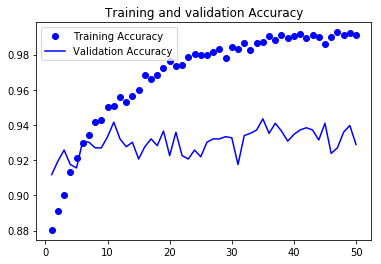

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.show()

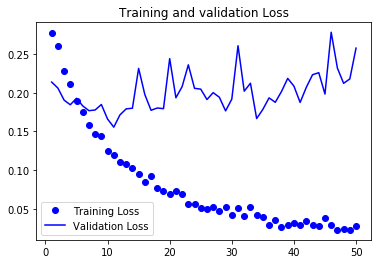

In [14]:
acc = history.history['loss']
val_acc = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training Loss')
plt.plot(epochs, val_acc, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.show()

## Model Saving

In [15]:
model.save('./models/vgg_fine_tuning_cats_and_dogs.h5')